# Introduction

## What is A/B Testing?

* Test different ideas against each other in the real world. 
* Choose the idea that statistically performs better.

## Why A/B Testing?

* No guessing
* Provide accurate answers quickly
* Allows rapidly iterate on ideas
* The only statistically sound way to establish causal relationship

## How to A/B test?

1) Develop hypothesis about you product and business

2) Randomly assign users to two different groups

3) Expose:
    * Group 1 to the current product rules (control group)
    * Group 2 to a product that tests the hypothesis (treatment group)

4) Pick whichever performs better according to a set of KPIs

## Where can A/B Testing be Used?

As long as there is users and ideas. Exp:

* Drug testing
* Mobile Games 
* Subscription
* and many more!

## About the dataset

Meditation App 

Services:
* Paid Subscription
* In-app purchase

Goals/KPIs:
* Maintain high free -> paid conversion rate

Conversion rate: % of users who subscribe after the free trial

# Import Packages, Dataset

In [77]:
import pandas as pd
import datetime
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm

## User Demographics

In [2]:
customer_data = pd.read_csv("Datasets/customer_dataset.csv")
customer_data['uid'] = customer_data['uid'].astype(int)
customer_data['reg_date'] = pd.to_datetime(customer_data['reg_date']).dt.date.astype('datetime64')
customer_data.head()

,uid,reg_date,device,gender,country,age
0,54030035,2017-06-29,and,M,USA,19
1,72574201,2018-03-05,iOS,F,TUR,22
2,64187558,2016-02-07,iOS,M,USA,16
3,92513925,2017-05-25,and,M,BRA,41
4,99231338,2017-03-26,iOS,M,FRA,59


In [3]:
customer_data.dtypes

uid                  int64
reg_date    datetime64[ns]
device              object
gender              object
country             object
age                  int64
dtype: object

In [4]:
customer_data.shape

(10000, 6)

## User Actions

In [5]:
app_purchases = pd.read_csv("Datasets/purchase_data_v1.csv")
app_purchases['date'] = pd.to_datetime(app_purchases['date']).dt.date.astype('datetime64')
app_purchases.head()

,date,uid,sku,price
0,2017-07-10,41195147,sku_three_499,499
1,2017-07-15,41195147,sku_three_499,499
2,2017-11-12,41195147,sku_four_599,599
3,2017-09-26,91591874,sku_two_299,299
4,2017-12-01,91591874,sku_four_599,599


In [6]:
app_purchases.dtypes

date     datetime64[ns]
uid               int64
sku              object
price             int64
dtype: object

In [7]:
app_purchases.shape

(9006, 4)

## Daily Revenue

In [8]:
revenue = pd.read_csv("Datasets/daily_revenue.csv", parse_dates=True, infer_datetime_format=True)
revenue['date'] = pd.to_datetime(revenue['date']).dt.date.astype('datetime64')
revenue.head()

,index,gender,device,revenue,date,country
0,1,male,ios,186557.0,2013-09-20,USA
1,2,male,ios,177217.0,2013-09-21,USA
2,3,male,ios,177197.0,2013-09-22,USA
3,4,male,ios,157193.0,2013-09-23,USA
4,5,male,ios,165592.0,2013-09-24,USA


In [9]:
revenue.dtypes

index               int64
gender             object
device             object
revenue           float64
date       datetime64[ns]
country            object
dtype: object

In [10]:
revenue.shape

(48000, 6)

## Paywall

In [11]:
user_demo_paywall = pd.read_csv("Datasets/user_demographics_paywall.csv")
user_demo_paywall['reg_date'] = pd.to_datetime(user_demo_paywall['reg_date']).dt.date.astype('datetime64')
user_demo_paywall = user_demo_paywall.sort_values('reg_date')
user_demo_paywall.head()

,uid,reg_date,device,gender,country,age
580,73890301,2015-02-04,iOS,M,USA,20
1065,59349028,2015-03-20,and,M,FRA,24
677,69049973,2015-03-24,iOS,M,USA,23
750,48143234,2015-04-14,and,M,USA,30
454,82718727,2015-04-17,iOS,F,USA,17


In [12]:
print(min(user_demo_paywall['reg_date']))
print(max(user_demo_paywall['reg_date']))

2015-02-04 00:00:00
2018-03-16 00:00:00


In [13]:
user_demo_paywall.shape

(1100, 6)

## ab_test

In [14]:
ab_test = pd.read_csv("Datasets/AB_testing_exercise.csv")
ab_test.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [15]:
ab_test.shape

(45883, 8)

# KPI

## Conversion Rate

In [16]:
# Print the columns of customer data
print(customer_data.columns)

# Print the columns of app_purchases
print(app_purchases.columns)

Index(['uid', 'reg_date', 'device', 'gender', 'country', 'age'], dtype='object')
Index(['date', 'uid', 'sku', 'price'], dtype='object')


In [17]:
purchase_data = app_purchases.merge(customer_data, how = 'inner', on=['uid'])
purchase_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26,and,M,BRA,17
3,2017-09-26,91591874,sku_two_299,299,2017-01-05,and,M,TUR,17
4,2017-12-01,91591874,sku_four_599,599,2017-01-05,and,M,TUR,17


In [18]:
purchase_data.shape

(9006, 9)

## Aggregate 

In [19]:
# Group the data 
grouped_purchase_data = purchase_data.groupby(by=['device', 'gender'])

# Aggregate the data
purchase_summary = grouped_purchase_data.agg({'price': ['mean', 'median', 'std']})

purchase_summary

price                   
                     mean median         std
device gender                               
and    F       400.747504    299  179.984378
       M       416.237308    499  195.001520
iOS    F       404.435330    299  181.524952
       M       405.272401    299  196.843197

## Calculating KPI

In [20]:
current_date = pd.to_datetime('2018-03-17')

# Compute max_purchase_date 
# Subtract timedelta(days=28) from current_date to find the last date that we will count purchases from. 
max_purchase_date = current_date - timedelta(days=28)

# Filter to only include users who registered before our max date
#Filter out all users in purchase_data who registered in the last 28 days.
purchase_data_filt = purchase_data[purchase_data.reg_date < max_purchase_date]

# Filter to contain only purchases within the first 28 days of registration
# reg_date = registration date
# date = purchase date
purchase_data_filt = purchase_data_filt[(purchase_data_filt.date <= 
                        purchase_data_filt.reg_date + timedelta(days=28))]

purchase_data_filt.head()

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26,and,M,BRA,17
19,2016-05-12,22870987,sku_four_599,599,2016-04-20,iOS,F,BRA,26
34,2017-01-12,88736154,sku_five_899,899,2017-01-08,and,F,BRA,19
92,2016-12-08,45588501,sku_four_599,599,2016-11-27,and,F,USA,49


In [21]:
# Output the mean price paid per purchase
purchase_data_filt.price.mean()

414.4237288135593

Interesting! Since our average price is 414 cents which is below $4.99 it seems that our purchasers tend towards the lower priced set of options.

## Average Purchase by Cohort

We can calculate these metrics across a set of cohorts and see what differences emerge. This is a useful task as it can help us understand how behaviors vary across cohorts.

In [22]:
# Set the max registration date to be one month before today
max_reg_date = current_date - timedelta(days=28)

# Find the month 1 values
month1 = np.where((purchase_data.reg_date < max_reg_date) &
                 (purchase_data.date < purchase_data.reg_date + timedelta(days=28)),
                  purchase_data.price, 
                  np.NaN)
                 
# Update the value in the DataFrame
purchase_data['month1'] = month1

# Group the data by gender and device 
purchase_data_upd = purchase_data.groupby(by=['gender', 'device'], as_index=False) 

# Aggregate the month1 and price data 
purchase_summary = purchase_data_upd.agg(
                        {'month1': ['mean', 'median'],
                        'price': ['mean', 'median']})

purchase_summary

gender device      month1              price       
                       mean median        mean median
0      F    and  388.204545  299.0  400.747504    299
1      F    iOS  432.587786  499.0  404.435330    299
2      M    and  413.705882  399.0  416.237308    499
3      M    iOS  433.313725  499.0  405.272401    299

In [23]:
purchase_data_upd

# EDA

## Moving Averages

In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

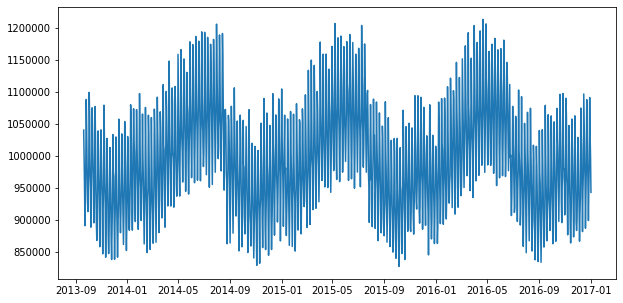

In [25]:
plt.figure(figsize=(10,5))
daily_revenue = revenue.groupby('date', as_index=False).agg('sum').drop('index',axis = 1)
plt.plot('date', 'revenue', data = daily_revenue)
plt.show()

There are so many variation in the revenue. To smoothen this, lets try moving average.

<Figure size 720x360 with 0 Axes>

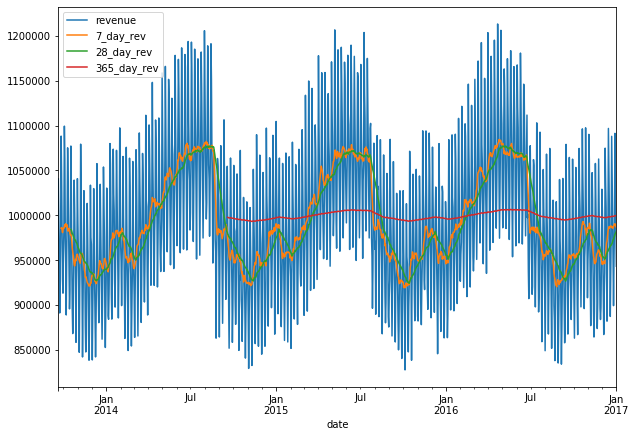

In [26]:
# Compute 7_day_rev
daily_revenue['7_day_rev'] = daily_revenue.revenue.rolling(window=7,center=False).mean()

# Compute 28_day_rev
daily_revenue['28_day_rev'] = daily_revenue.revenue.rolling(window=28,center=False).mean()
    
# Compute 365_day_rev
daily_revenue['365_day_rev'] = daily_revenue.revenue.rolling(window=365,center=False).mean()


plt.figure(figsize=(10,5))
# Plot date, and revenue, along with the 3 rolling functions (in order)    
daily_revenue.plot(x='date', 
                   y=['revenue', '7_day_rev', '28_day_rev', '365_day_rev', ], 
                   figsize=(10,7))
plt.show()

## Exponential Rolling Average 

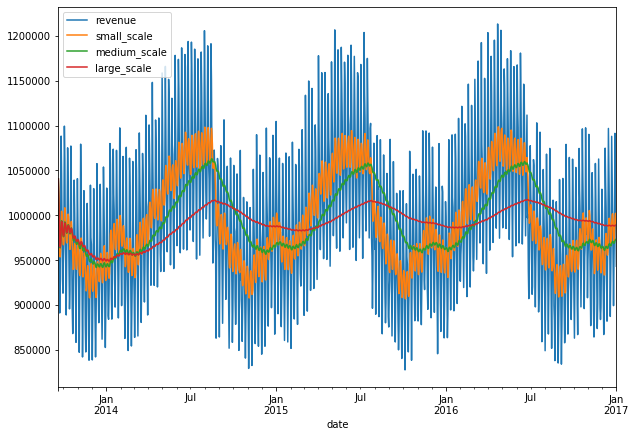

In [27]:
# Calculate 'small_scale'
daily_revenue['small_scale'] = daily_revenue.revenue.ewm(span=10).mean()

# Calculate 'medium_scale'
daily_revenue['medium_scale'] = daily_revenue.revenue.ewm(span=100).mean()

# Calculate 'large_scale'
daily_revenue['large_scale'] = daily_revenue.revenue.ewm(span=500).mean()

# Plot 'date' on the x-axis and, our three averages and 'revenue'
# on the y-axis
daily_revenue.plot(x = 'date', y =['revenue', 'small_scale', 'medium_scale', 'large_scale'], figsize=(10,7))
plt.show()

## User Revenue

In [28]:
user_revenue = revenue.copy()
user_revenue['month'] = user_revenue['date'].dt.to_period('M').dt.to_timestamp()
user_revenue = user_revenue.groupby(['month', 'gender', 'device'], as_index = False).agg('sum')
user_revenue.head()

,month,gender,device,index,revenue
0,2013-09-01,female,android,660,1144057.0
1,2013-09-01,female,ios,660,1543801.0
2,2013-09-01,male,android,660,3447967.0
3,2013-09-01,male,ios,660,4631978.0
4,2013-10-01,female,android,8370,3233420.0


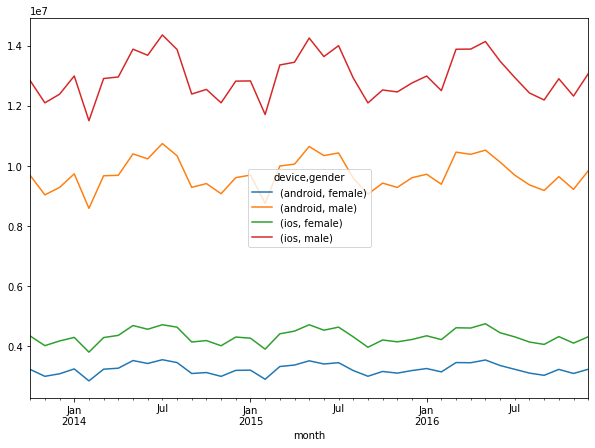

In [29]:
# Pivot user_revenue
pivoted_data = pd.pivot_table(user_revenue, values ='revenue', columns=['device', 'gender'], index='month')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

# Create and show the plot
pivoted_data.plot(figsize=(10,7))
plt.show()

 it seems like our aggregate revenue is fairly stable, so the changes are most likely not hurting revenue.

# A/B Testing

A/B test needs to be random because:

* isolate the impact of the change made

* reduce the potential impact of confounding variables

## Revenue per user day

In [30]:
purchase_data = app_purchases.merge(customer_data, on='uid', how='left').sort_values(by='uid')
purchase_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age
1309,2018-03-13,11158549,sku_two_299,299,2016-11-09,and,F,BRA,18
1306,2017-09-25,11158549,sku_three_499,499,2016-11-09,and,F,BRA,18
1307,2017-12-02,11158549,sku_four_599,599,2016-11-09,and,F,BRA,18
1308,2018-02-11,11158549,sku_four_599,599,2016-11-09,and,F,BRA,18
1310,2018-03-16,11158549,sku_two_299,299,2016-11-09,and,F,BRA,18


In [31]:
# Extract the 'day'; value from the timestamp
purchase_data.date = purchase_data.date.dt.floor('d')

# Replace the NaN price values with 0 
purchase_data.price = np.where(np.isnan(purchase_data.price), 0, purchase_data.price)

# Aggregate the data by 'uid' & 'date'
purchase_data_agg = purchase_data.groupby(by=['uid', 'date'], as_index=False)
revenue_user_day = purchase_data_agg.sum()

# Calculate the final average
revenue_user_day = revenue_user_day.price.mean()
print(revenue_user_day)

407.95033407572384


In [32]:
# Group and aggregate our combined dataset 
daily_purchase_data = purchase_data.groupby(by=['date'], as_index=False)
daily_purchase_data = daily_purchase_data.agg({'price': ['sum', 'count']})
daily_purchase_data.head()

date price      
               sum count
0 2015-03-02   199     1
1 2015-04-04   299     1
2 2015-04-10   199     1
3 2015-04-15  1098     2
4 2015-05-05   299     1

In [33]:
# Find the mean of each field and then multiply by 1000 to scale the result
daily_purchases = daily_purchase_data.price['sum'].mean()
daily_paywall_views = daily_purchase_data.price['count'].mean()
daily_purchases = daily_purchases * 1000
daily_paywall_views = daily_paywall_views * 1000
print(daily_purchases)
print(daily_paywall_views)

3670735.4709418835
9024.048096192384


In [34]:
purchase = ab_test[['date', 'uid', 'gender', 'spent', 'purchases', 'country']]
purchase.head()

,date,uid,gender,spent,purchases,country
0,2016-03-08,11115722,F,1595,5,MEX
1,2017-07-14,11122053,M,498,2,USA
2,2017-09-17,11128688,F,2394,6,USA
3,2017-11-30,11130578,F,1197,3,USA
4,2018-01-10,11130759,M,1297,3,ESP


In [35]:
# Mean
avg_purchase = np.mean(purchase['purchases'])
print(avg_purchase)

# Standard Dev in purchases
purchase_var = purchase['purchases'].std()
print(purchase_var)

print(purchase_var/avg_purchase)

4.54438463047316
3.1024539260247788
0.6827005586676654


In [36]:
# Price in cents
avg_revenue = np.mean(purchase['spent'])/100
np.round(avg_revenue,3)

18.835

# Analyzing Data

In [37]:
ab_test.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


## Are the group the same size?

In [38]:
test_results_grpd = ab_test.groupby(by=['group'], as_index=False)
test_results_grpd.uid.count()

,group,uid
0,GRP A,23009
1,GRP B,22874


The group is about the same size

In [39]:
# Find the unique users in each group 
results = ab_test.groupby('group').agg({'uid': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test.uid.unique()) 
unique_users

45883

## Do our groups have similar demographics

In [40]:
test_results_grpd = ab_test.groupby(by=['country', 'gender', 'device', 'group'], as_index=False)
test_results_grpd.uid.count().head()

,country,gender,device,group,uid
0,AUS,F,A,GRP A,134
1,AUS,F,A,GRP B,130
2,AUS,F,I,GRP A,130
3,AUS,F,I,GRP B,133
4,AUS,M,A,GRP A,133


## Test & Control Group Conversion Rates

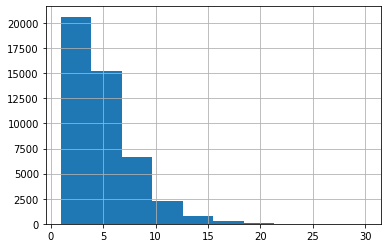

In [41]:
ab_test['purchases'].hist()

In [42]:
ab_test_summ = ab_test.groupby(by=['group'], as_index=False).agg({'purchases': ['count', 'sum']})
ab_test_summ['conv'] = ab_test_summ.purchases['count']/ab_test_summ.purchases['sum']
ab_test_summ

group purchases              conv
             count     sum          
0  GRP A     23009  104377  0.220441
1  GRP B     22874  104133  0.219661

## Is result statistically significant?

### Calculate p-values

In [53]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

In [59]:
# Control Conversion Rate
cont_conv = 0.09096495570387314
# Test Conversion Rate
test_conv = 0.1020053238686779
# Control Group Size 
cont_size = 5329
# Test Group Size
test_size = 5748

# Compute the p-value
p_value = get_pvalue(con_conv=cont_conv, test_conv=test_conv, con_size=cont_size, test_size=test_size)
print(p_value)

# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

0.04900185792087508
Significant Result


### Confidence Interval

In [62]:
def get_ci(value, cl, sd):
    loc = norm.ppf(1 - cl/2)
    rng_val = norm.cdf(loc - value/sd)
    
    lwr_bnd = value - rng_val
    upr_bnd = value + rng_val 
    
    return_val = (lwr_bnd, upr_bnd)
    return(return_val)

In [63]:
# Calculate the mean of our lift distribution 
lift_mean = test_conv - cont_conv

# Calculate variance and standard deviation 
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - cont_conv) * cont_conv / cont_size
lift_sd = lift_variance**0.5

# Find the confidence intervals with cl = 0.95
confidence_interval = get_ci(lift_mean, 0.95, lift_sd)
print(confidence_interval)

(-0.01729325163576479, 0.039373987965374314)


### Visualize Result

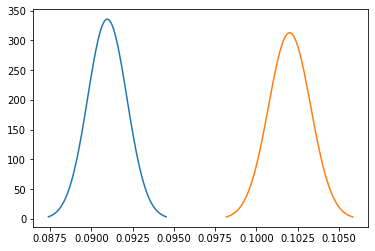

In [79]:
cont_var = 1.411507925080655e-06
test_var = 1.6255542142857143e-06

# Compute the standard deviations
control_sd = cont_var**0.5
test_sd = test_var**0.5

# Create the range of x values 
control_line = np.linspace(cont_conv - 3 * control_sd, cont_conv + 3 * control_sd, 100)
test_line = np.linspace(test_conv - 3 * test_sd ,test_conv +  3 * test_sd, 100)

# Plot the distribution     
plt.plot(control_line, norm.pdf(control_line, cont_conv, control_sd))
plt.plot(test_line, norm.pdf(test_line, test_conv, test_sd))
plt.show()

We see no overlap, which intuitively implies that our test and control conversion rates are significantly distinct.

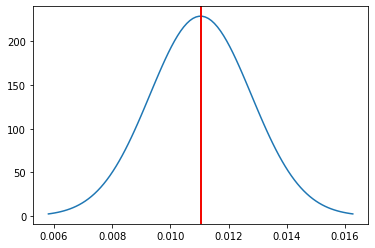

In [81]:
# Find the lift mean and standard deviation
lift_mean = test_conv - cont_conv
lift_sd = (test_var + cont_var) ** 0.5

# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)

# Plot the lift distribution
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))

lwr_ci = 0.01103999822042502
upr_ci = 0.011040000177957487

# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = lwr_ci, color = 'red')
plt.axvline(x = upr_ci, color = 'red')
plt.show()